In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from tensorflow.keras.utils import load_img, img_to_array

# Verzeichnis mit unseren Trainingsdaten der Klasse 'car'
train_cars_dir = os.path.join('./data/vehicles')
test_cars_dir = os.path.join('./Test/vehicles')
validation_cars_dir = os.path.join('./Validation/vehicles')

# Verzeichnis mit unseren Trainingsdaten der Klasse 'nocar'
train_nocars_dir = os.path.join('./data/non-vehicles')
test_nocars_dir = os.path.join('./Test/non-vehicles')
validation_nocars_dir = os.path.join('./Validation/non-vehicles')



#train_cars_names = os.listdir(train_cars_dir)
#train_nocars_names = os.listdir(train_nocars_dir)

print('Anzahl Bilder im Verzeichnis Cars:', len(os.listdir(train_cars_dir)))
print('Anzahl Bilder im Verzeichnis no Cars:', len(os.listdir(train_nocars_dir)))

/Users/cristobalschmidt/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Anzahl Bilder im Verzeichnis Cars: 14936
Anzahl Bilder im Verzeichnis no Cars: 10217


In [2]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Zähle die Anzahl der Bilder im Trainingsverzeichnis
num_train_images = len(os.listdir(train_cars_dir)) + len(os.listdir(train_nocars_dir))

batchsize = 10
batchsize_val = 10
epochen = 5

# Berechne die Schritte pro Epoche
stepsperepoch = 1376
#int((num_train_images / batchsize)/20)

# Bilder aus dem Trainingsdatensatz fließen in Paketen (batches) von 128 in train_datagen
train_generator = train_datagen.flow_from_directory(
        './data/',  # Quellverzeichnis für Trainingsdaten
        target_size=(64, 64),  # Alle Bilder werden auf 300x300 Pixel skaliert
        batch_size=batchsize,
        # Konfiguriere Labels für eine binäre Klassifikation
        class_mode='binary')

# Bilder aus dem Trainingsdatensatz fließen in Paketen (batches) von 128 in train_datagen
validation_generator = validation_datagen.flow_from_directory(
        './Validation/',  # Quellverzeichnis für Trainingsdaten
        target_size=(64, 64),  # Alle Bilder werden auf 300x300 Pixel skaliert
        batch_size=batchsize_val,
        # Konfiguriere Labels für eine binäre Klassifikation
        class_mode='binary')

Found 25153 images belonging to 2 classes.
Found 9541 images belonging to 2 classes.


In [3]:
model = tf.keras.models.Sequential([
    # Erste Faltungsschicht
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Zweite Faltungsschicht
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Dritte Faltungsschicht
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Vierte Faltungsschicht
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten und Dense-Schicht
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # Output layer mit einem Künstlichen Neuron, Wertebereich 0-1
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

/Users/cristobalschmidt/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 623,265 (2.38 MB)

 Trainable params: 623,265 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(
      train_generator,
      #steps_per_epoch=stepsperepoch,  
      epochs=epochen,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)


Epoch 1/5
   3/2516 ━━━━━━━━━━━━━━━━━━━━ 1:12 29ms/step - accuracy: 0.4278 - loss: 0.6671  

/Users/cristobalschmidt/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2516/2516 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.8732 - loss: 0.2923 - val_accuracy: 0.9125 - val_loss: 0.3132
Epoch 2/5
2516/2516 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.9634 - loss: 0.1061 - val_accuracy: 0.9750 - val_loss: 0.0463
Epoch 3/5
2516/2516 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.9730 - loss: 0.0711 - val_accuracy: 0.9500 - val_loss: 0.1562
Epoch 4/5
2516/2516 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.9790 - loss: 0.0583 - val_accuracy: 0.9875 - val_loss: 0.0343
Epoch 5/5
2516/2516 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.9842 - loss: 0.0498 - val_accuracy: 0.9500 - val_loss: 0.0998


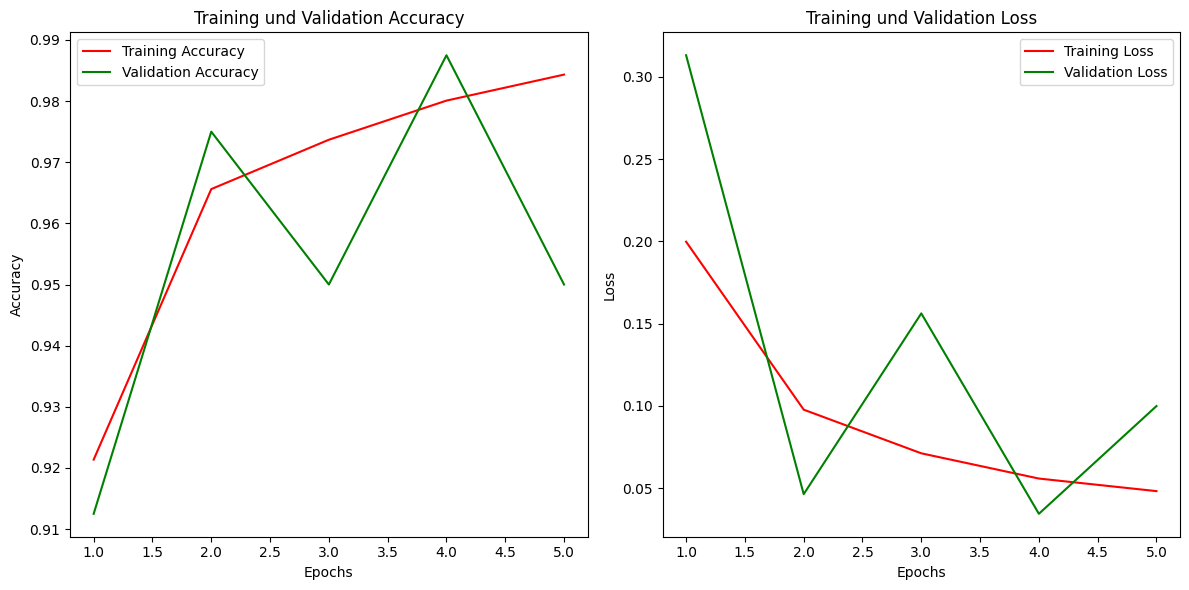

In [5]:
# Zugriff auf die Metriken aus dem history-Objekt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

for i in range(len(val_accuracy)):
    if val_accuracy[i] < 10e-8:
        if i < (len(val_accuracy)-1) and i > 0:
            val_accuracy[i] = (val_accuracy[i-1]+val_accuracy[i+1])/2
        elif i > 0:
            val_accuracy[i] = val_accuracy[i-1]
        else:
            val_accuracy[i] = val_accuracy[i+1]

    if val_loss[i] < 10e-8:
        if i < (len(val_accuracy)-1) and i>0:
            val_loss[i] = (val_loss[i-1]+val_loss[i+1])/2
        elif i > 0:
            val_loss[i] = val_loss[i-1]
        else:
            val_loss[i] = val_loss[i+1]


# Zugriff auf die Anzahl der Epochen
epochs = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training und Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training und Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
# Verzeichnis mit den Testdaten
test_dir = './Test/'

# ImageDataGenerator für Testdaten
test_datagen = ImageDataGenerator(rescale=1/255)

# Generator für Testdaten
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=batchsize,
    class_mode='binary'
)

# Modell auf Testdaten evaluieren
eval_result = model.evaluate(test_generator)

# Ausgabe von Genauigkeit und Verlust
print("Test Genauigkeit:", eval_result[1])
print("Test Verlust:", eval_result[0])


Found 5406 images belonging to 2 classes.
541/541 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9730 - loss: 0.0749
Test Genauigkeit: 0.9755826592445374
Test Verlust: 0.07058385014533997


In [7]:
model.save('/Users/cristobalschmidt/DeepDrive2.0/h5_'+str(epochen)+'epochs.keras')